In [5]:
import gymnasium as gym
import numpy as np
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import cv2
import os

from gymnasium.spaces import Box
from IPython.display import clear_output

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SIZE = 10000
BATCH_SIZE = 32
EPS_MAX = 0.95
EPS_MIN = 0.1
EPS_DECAY = 1000
DROP = 0.2
GAMMA = 0.95
LR = 0.001

In [13]:
def plot_observation(observation):
    frame_count = observation.shape[0]
    _, axes = plt.subplots(1, frame_count, figsize=(frame_count*4, 5))
    for i in range(frame_count):
        axes[i].imshow(observation[i], cmap='gray')
        axes[i].axis('off')
    plt.show()
def show_img(img, hide_colorbar=False):
    if len(img.shape) < 3 or img.shape[2] == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)

    if not hide_colorbar:
        plt.colorbar()
def prepend_tuple(new_dim, some_shape):
    some_shape_list = list(some_shape)
    some_shape_list.insert(0, new_dim)
    return tuple(some_shape_list)


def replace_color(data, original, new_value):
    r1, g1, b1 = original
    r2, g2, b2 = new_value

    red, green, blue = data[:,:,0], data[:,:,1], data[:,:,2]
    mask = (red == r1) & (green == g1) & (blue == b1)
    data[:,:,:3][mask] = [r2, g2, b2]

def convert2tensor(array):
    if torch.is_tensor(array):
        return array
    return torch.tensor(array, dtype=torch.float32).to(DEVICE)

In [14]:
class GameEnv(gym.Wrapper):
    def __init__(self, env):
        super(GameEnv, self).__init__(env)
        self.action_space = self.env.action_space
        self.frame_skip = 4
        self.frame_stack = 4
        self.observation_space = Box(0, 255, self.reset()[0].shape, dtype=np.uint8)
        self.last_stack = np.array([])

    def skip_frames(self, action, skip_count=100):
        total_reward = 0 # not sure
        if torch.is_tensor(action):
            action = action.to('cpu').numpy()
        for _ in range(skip_count):
            observation, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward 
            if terminated or truncated:
                break
        return observation, total_reward/float(skip_count), terminated, truncated, info

    def stack_frames(self, new_frame, reset=False):
        if reset:
            self.last_stack = np.tile(new_frame, (self.frame_stack, 1, 1))
        else:
            self.last_stack = np.concatenate((self.last_stack[1:], new_frame[np.newaxis]), axis=0)
        return self.last_stack
    
    def process_image(self, observation):
        for i in range(86, 93+1):
            observation[i, 0:12, :] = observation[i, 12, :]
        for i in range(200, 230):
            replace_color(observation, original=(100, i, 100), new_value=(100, 202, 100))
        
        observation[66:77, 45:51] = 0
        observation = cv2.cvtColor(np.array(observation), cv2.COLOR_BGR2GRAY)/255.0 # normalize
            # Scale from 0 to 1
        observation = observation / observation.max()
        return observation

    def reset(self, **kwargs):
        observation, info = self.env.reset(**kwargs)
        observation, _, _, _, info = self.skip_frames([0,0,0])
        observation = self.process_image(observation)
        observation = self.stack_frames(observation, True)

        return observation, info

    def step(self, action):
        observation, total_reward, terminated, truncated, info = self.skip_frames(action, self.frame_skip)
        observation = self.process_image(observation)
        observation = self.stack_frames(observation)

        return observation, total_reward, terminated, truncated, info

In [15]:
transition = namedtuple("Transition", ("state","action", "reward", "next_state"))

class ReplayMemory():
    def __init__(self, state_shape, action_shape):
        self.state = convert2tensor(np.zeros((MAX_SIZE, *state_shape)))
        self.action = convert2tensor(np.zeros((MAX_SIZE, action_shape)))
        self.reward = convert2tensor(np.zeros((MAX_SIZE, 1), dtype=float))
        self.next_state = convert2tensor(np.zeros((MAX_SIZE, *state_shape)))

        self.current_size = 0

    def push(self, transition):
        self.state[self.current_size] = convert2tensor(np.array(transition.state))
        self.action[self.current_size] = convert2tensor(transition.action)
        self.reward[self.current_size] = convert2tensor(np.array(transition.reward))
        self.next_state[self.current_size] = convert2tensor(np.array(transition.next_state))

        self.current_size = (self.current_size + 1) % MAX_SIZE

    def sample(self):
        sample_idx = np.random.randint(len(self.state), size=(min(self.current_size, BATCH_SIZE))) 
        return self.state[sample_idx], self.action[sample_idx], self.reward[sample_idx], self.next_state[sample_idx]

In [16]:
class ActorNet(nn.Module):
    def __init__(self, state, possible_actions):
        super(ActorNet, self).__init__()
        input_channel = state.shape[0]
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        self.layer1 = nn.Conv2d(input_channel, 16, kernel_size=5, stride=4, padding='valid').to(DEVICE) # 41x41
        self.layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=3, padding='valid').to(DEVICE) # 41x41
        self.layer3 = nn.Conv2d(32, 32, kernel_size=3, stride=3, padding='valid').to(DEVICE) # 41x41

        with torch.no_grad():
            x = F.relu(self.layer1(state))
            x = F.relu(self.layer2(x))
            x = F.relu(self.layer3(x))
            dense_input = x.shape[2]
        
        self.fc1 = nn.Linear(32*dense_input*dense_input, 64).to(DEVICE)
        self.fc2 = nn.Linear(64, possible_actions).to(DEVICE)
    
    def forward(self, state):
        out = self.layer1(state)
        out = F.relu(out)

        out = self.layer2(out)
        out = F.relu(out)

        out = self.layer3(out)
        out = F.relu(out)

        out = out.reshape(out.size(0), -1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return F.softmax(out, dim=1)
    

In [17]:
class CriticNet(nn.Module):
    def __init__(self, state, possible_actions):
        super(CriticNet, self).__init__()
        input_channel = state.shape[0]
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        self.layer1 = nn.Conv2d(input_channel, 16, kernel_size=5, stride=4, padding='valid').to(DEVICE) # 41x41
        self.layer2 = nn.Conv2d(16, 32, kernel_size=3, stride=3, padding='valid').to(DEVICE) # 41x41
        self.layer3 = nn.Conv2d(32, 32, kernel_size=3, stride=3, padding='valid').to(DEVICE) # 41x41

        with torch.no_grad():
            x = F.relu(self.layer1(state))
            x = F.relu(self.layer2(x))
            x = F.relu(self.layer3(x))
            dense_input = x.shape[2]
        
        self.fc1 = nn.Linear(32*dense_input*dense_input+possible_actions, 64).to(DEVICE)
        self.fc2 = nn.Linear(64, 1).to(DEVICE)
    
    def forward(self, state, action):
        out = self.layer1(state)
        out = F.relu(out)

        out = self.layer2(out)
        out = F.relu(out)

        out = self.layer3(out)
        out = F.relu(out)

        out = out.reshape(out.size(0), -1)
        out = torch.concatenate((out, action), 1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return F.softmax(out, dim=1)

In [18]:
class NoiseGenerator:
    def __init__(self, mean, std_dev, theta=0.3, dt=5e-2):
        self.theta = theta
        self.dt = dt
        self.mean = mean
        self.std_dev = std_dev

        if mean.shape != std_dev.shape:
            raise ValueError('Mean shape: {} and std_dev shape: {} should be the same!'.format(
                mean.shape, std_dev.shape))

        # This shape will be generated
        self.x_shape = mean.shape
        self.x = None

        self.reset()

    def reset(self):
        # Reinitialize generator
        self.x = np.zeros_like(self.x_shape)

    def generate(self):
        # The result is based on the old value
        # The second segment will keep values near a mean value
        # It uses normal distribution multiplied by a standard deviation
        self.x = (self.x
                  + self.theta * (self.mean - self.x) * self.dt
                  + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.x_shape))

        # TODO: check if decaying noise helps
        # self.std_dev = self.std_dev * 0.9999
        return self.x

In [24]:
class DDPG(nn.Module):
    def __init__(self, state, actions, action_space, noise_mean=None, noise_std=None):
        super(DDPG, self).__init__()

        self.memory = ReplayMemory(state.shape, actions)
        self.action_space = action_space

        self.actor = ActorNet(state, actions)
        self.actor_target = ActorNet(state, actions)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = CriticNet(state, actions)
        self.critic_target = CriticNet(state, actions)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.gamma = 0.99
        self.actor_lr = 0.00001
        self.critic_lr = 0.002
        self.tau = 0.005
        self.memory_capacity = 60000

        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=self.critic_lr)
        self.loss = nn.MSELoss(reduction='mean')

        # Init noise generator
        if noise_mean is None:
            noise_mean = np.full(actions, 0.0, np.float32)
        if noise_std is None:
            noise_std  = np.full(actions, 0.2, np.float32)
        self.noise = NoiseGenerator(noise_mean, noise_std)
    
    def reset(self):
        self.noise.reset()

    def select_action(self, state, training=True):
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            action = self.actor(state.unsqueeze(0))
        
        # add noise
        if training:
            action = action[0] + torch.tensor(self.noise.generate(), dtype=torch.float32, device=DEVICE)
        else:
            action = action[0]

        real_action = convert2tensor([action[0].item(), action[1].clip(0, 1).item(), -action[1].clip(-1, 0).item()])
        real_action = torch.clip(real_action, min=convert2tensor(self.action_space.low), max=convert2tensor(self.action_space.high))

        return action, real_action
    
    def learn(self):
        state, action, reward, next_state = self.memory.sample()

        next_action = self.actor_target(next_state)
        y = reward + self.gamma * self.critic_target(next_state, next_action)

        loss_critic = self.loss(y,self.critic(state, action))
        self.optimizer_critic.zero_grad()
        loss_critic.backward()
        self.optimizer_critic.step()
        
        loss_actor = -self.critic(state, self.actor(state)).mean()
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        self.optimizer_actor.step()

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def save_models(self, episode):
        if not os.path.exists(f'models/1'):
            os.makedirs(f'models/1')
            
        torch.save(self.actor.state_dict(), f'models/{episode}/actor.pt')
        torch.save(self.critic.state_dict(), f'models/{episode}/critic.pt')
        torch.save(self.actor_target.state_dict(), f'models/{episode}/actor_target.pt')
        torch.save(self.critic_target.state_dict(), f'models/{episode}/critic_target.pt')

    def load_models(self):
        self.actor.load_state_dict(torch.load("gym-rl-car-racing/models/actor.pt")) 
        self.critic.load_state_dict(torch.load("gym-rl-car-racing/models/critic.pt")) 
        self.actor_target.load_state_dict(torch.load("gym-rl-car-racing/models/actor_target.pt")) 
        self.critic_target.load_state_dict(torch.load("gym-rl-car-racing/models/critic_target.pt")) 

: 

In [32]:
import numpy as np

es = torch.tensor(np.random.rand(3), dtype=torch.float32).to(DEVICE)

In [34]:
es * 0.5

tensor([0.4999, 0.4869, 0.3803], device='cuda:0')

In [3]:
env = gym.make('CarRacing-v2', continuous=True, render_mode="rgb_array")
observation, _ = env.reset()
observation, total_reward, terminated, truncated, info = env.step(env.action_space.sample())

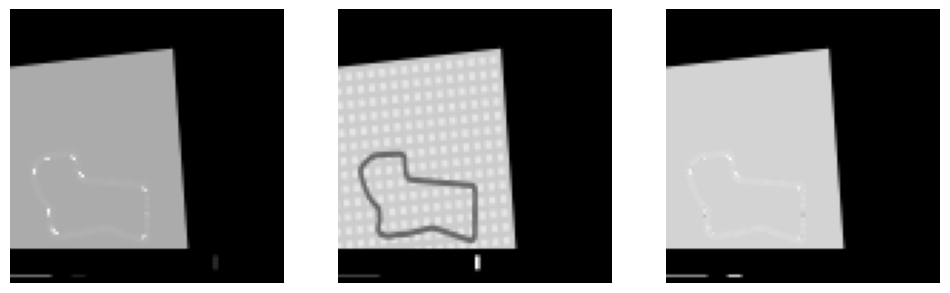

In [10]:
for i in range(86, 93+1):
    observation[i, 0:12, :] = observation[i, 12, :]
plot_observation(np.moveaxis(observation, -1, 0))

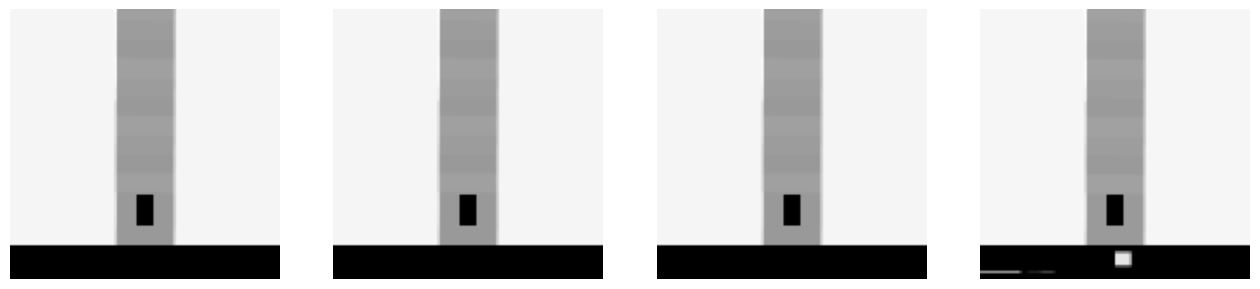

In [11]:
plot_observation(observation)

In [20]:
n_episodes = 50000
save_model_freq = 1
save_reward_freq = 1


env = GameEnv(gym.make('CarRacing-v2', continuous=True, render_mode="rgb_array"))
state, _ = env.reset()
all_episode_reward = []
history = {'Episode': [], 'AvgReturn': []}

noise_std = np.array([0.1, 4 * 0.2], dtype=np.float32)
agent = DDPG(state, 2, env.action_space, noise_std=noise_std)
agent.reset()


# Loop of episodes
for ie in range(n_episodes):
    state, _ = env.reset()
    agent.reset()
    done = False
    episode_reward = 0
    no_reward_counter = 0

    # One-step-loop
    while not done:

        train_action, real_action = agent.select_action(state)

        # This will make steering much easier
        real_action /= 4
        next_state, reward, terminated, truncated, info = env.step(real_action)
        done = terminated or truncated

        # Models action output has a different shape for this problem
        agent.memory.push(transition(state, train_action, reward, next_state))
        agent.learn()

        state = next_state
        episode_reward += reward

        if reward < 0:
            no_reward_counter += 1
            if no_reward_counter > 200:
                break
        else:
            no_reward_counter = 0

    all_episode_reward.append(episode_reward)
    average_result = np.array(all_episode_reward[-10:]).mean()
    print('Last result:', episode_reward, 'Average results:', average_result)


    if ie % save_reward_freq == 0:
        history['Episode'].append(ie)
        history['AvgReturn'].append(average_result)

    if ie % save_model_freq == 0 and ie > 0:
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Episode'], history['AvgReturn'], 'r-')
        plt.xlabel('Episode', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.savefig("rewards.png")
        print('Saving best solution')
        torch.save(agent.save_models(ie), f'dqn{ie}.pt')

KeyboardInterrupt: 

In [23]:
env = GameEnv(gym.make('CarRacing-v2', continuous=True, render_mode="human"))
state, _ = env.reset()
agent = DDPG(state, 2, env.action_space)
agent.load_models()
for ie in range(5):
    state, _ = env.reset()
    agent.reset()
    done = False
    # One-step-loop
    while not done:

        train_action, real_action = agent.select_action(state, training=False)

        # This will make steering much easier
        real_action /= 4
        next_state, reward, terminated, truncated, info = env.step(real_action)
        done = terminated or truncated

        state = next_state

FileNotFoundError: [Errno 2] No such file or directory: 'gym-rl-car-racing\\models\x07ctor.pt'

In [3]:
import torch.nn.functional as F
import torch
F.softmax(torch.tensor([0.78], dtype=torch.float32, device='cuda'))

C:\Users\mertc\AppData\Local\Temp\ipykernel_13744\3019937839.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor([0.78], dtype=torch.float32, device='cuda'))


tensor([1.], device='cuda:0')